## Preprocessing

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing import text, sequence

df = pd.read_csv('clean-data.csv')
df.head()

,Unnamed: 0,sentiment,content
0,7,anger,Karev better not be out!!! Or I am seriously d...
1,9,anger,Boycotting @DunkinDonuts till butter pecan com...
2,43,anger,I HATE little girls 😡😡 got a lot off growing u...
3,182,anger,"@ChronAVT ummm, the blog says 'with Simon Steh..."
4,229,anger,@UlsterWillFight @VanguardBears Looks like a r...


In [2]:
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,sentiment,content
0,anger,Karev better not be out!!! Or I am seriously d...
1,anger,Boycotting @DunkinDonuts till butter pecan com...
2,anger,I HATE little girls 😡😡 got a lot off growing u...
3,anger,"@ChronAVT ummm, the blog says 'with Simon Steh..."
4,anger,@UlsterWillFight @VanguardBears Looks like a r...


In [3]:
y_pandas_df = pd.get_dummies(df['sentiment'])
print(type(y_pandas_df))
print(y_pandas_df.shape)
print(y_pandas_df.ndim)
y_pandas_df.head()

<class 'pandas.core.frame.DataFrame'>
(12636, 14)
2


,anger,boredom,empty,enthusiasm,fear,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
y = y_pandas_df.values

train_df = df.drop(['sentiment'], axis=1)

In [5]:
x = train_df.values.flatten()

In [6]:
list_of_classes = ['anger', 'boredom', 'empty', 'enthusiasm', 'fear', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']
max_features = 20000
max_text_length = 400
embedding_dims = 50

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=max_features,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    char_level=False,
    oov_token=None,
    document_count=0,
)

In [8]:
tokenizer.fit_on_texts(list(x))
x_tokenized = tokenizer.texts_to_sequences(x)
x_train = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state = 42)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dims, input_length=max_text_length),
    tf.keras.layers.Conv1D(256, kernel_size=(3), padding='same', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=(2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(list_of_classes), activation='softmax')
])

In [11]:
optim = tf.keras.optimizers.Adam(
    learning_rate=0.00075,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [12]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optim, metrics=['accuracy'])

In [13]:
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
1011/1011 [==============================] - 72s 71ms/step - loss: 2.4930 - accuracy: 0.1208
Epoch 2/10
1011/1011 [==============================] - 73s 72ms/step - loss: 2.1404 - accuracy: 0.2386
Epoch 3/10
1011/1011 [==============================] - 70s 69ms/step - loss: 1.7852 - accuracy: 0.3780
Epoch 4/10
1011/1011 [==============================] - 69s 69ms/step - loss: 1.3405 - accuracy: 0.5381
Epoch 5/10
1011/1011 [==============================] - 69s 69ms/step - loss: 0.9147 - accuracy: 0.6862
Epoch 6/10
1011/1011 [==============================] - 71s 70ms/step - loss: 0.6169 - accuracy: 0.7911
Epoch 7/10
1011/1011 [==============================] - 70s 70ms/step - loss: 0.4180 - accuracy: 0.8653
Epoch 8/10
1011/1011 [==============================] - 72s 71ms/step - loss: 0.2908 - accuracy: 0.9082
Epoch 9/10
1011/1011 [==============================] - 72s 71ms/step - loss: 0.2058 - accuracy: 0.9326
Epoch 10/10
1011/1011 [==============================] - 69s 68m

In [14]:
model.save('emotion-classifier-keras-model.h5')

In [15]:
y_pred = model.predict(x_test)

In [16]:
def pred(y_pred):
    y_pred = np.array(y_pred)
    global list_of_classes
    o = -1
    k = 0

    for i in range(len(list_of_classes)):
        if y_pred[i] > k:
            o = i
            k = y_pred[i]
    
    return list_of_classes[o]

In [17]:
y_predict = []

for i in range(len(x_test)):
    y_predict.append(pred(y_pred[i]))
    
y_true = []

for i in range(len(y_test)):
    y_true.append(pred(y_test[i]))

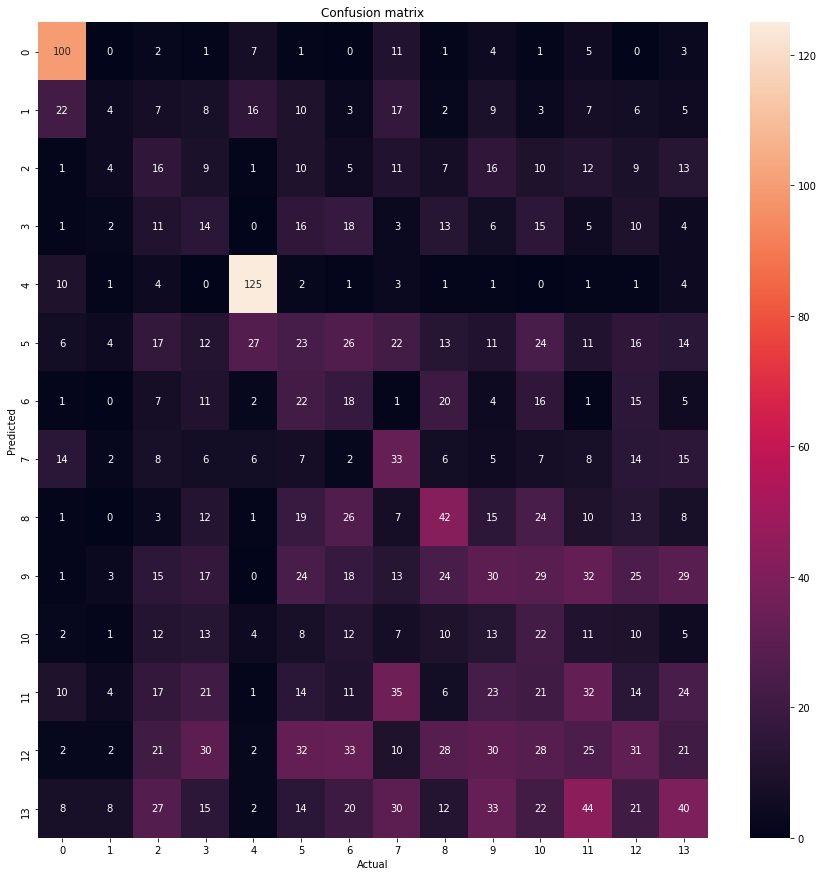

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_predict, y_true)

plt.figure(figsize=(15, 15))
plot = plt.subplot()
sns.heatmap(matrix, annot=True, ax=plot, fmt='g')

plot.set_title('Confusion matrix')
plot.set_xlabel('Actual')
plot.set_ylabel('Predicted')
plt.show()

In [19]:
total = len(y_test)
true = 0

for i in range(len(y_test)):
    if y_true[i] == y_predict[i]:
        true += 1
        
print('Accuracy on test data: ', true/total * 100, '%')

Accuracy on test data:  20.96518987341772 %
